In [1]:
execfile('preamble_and_functions.py')

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
### ------ the width of a time period ------ ###
Delta_t = 0.25

# storage properties
installedCap = 1 # kW
maxDOD = 0.85 # % equivalent full cycle (EFC)
EoL = 0.8 # end of life % equivalent full charge 
maxSOC = np.mean([EoL*installedCap, maxDOD*installedCap])# kWh
minSOC = 0 # kWh
maxChg = 0.5 # kW
maxDisChg = -0.5 # kW
etaChg = 0.948
etaDisChg = 0.948
storageProperties = []
storageProperties.append(maxSOC-minSOC) # kWh
storageProperties.append(maxChg) # kW maxChg
storageProperties.append(maxDisChg) # kW maxDisChg
storageProperties.append(etaChg) # etaChg
storageProperties.append(etaDisChg) # etaDisChg
billingOption = []
# if billingOption[1] == 1 then need a solar export price in billingOption[2], otherwise no
billingChoice = 1
priceExport = 5 # cents/kWh
# choose whether device is allowed to buy and sell back to grid
marketArbitrage = False
billingOption.append(billingChoice) 
billingOption.append(priceExport)
billingOption.append(marketArbitrage)

#### ---------- one price every Delta_t ----####
price = np.ones((96*30))*35 # cents per kWh
print maxSOC

0.825


In [3]:
filename = 'IntermediateData/Workspace96.csv'
WSpace = []
with open(filename) as InFile:
    reader = csv.reader(InFile, delimiter=',')
    for row in reader:
        WSpace.append(row)

In [4]:
generation = np.genfromtxt('IntermediateData/camGenJan.csv', delimiter=',', dtype=None)
print np.shape( generation )
gSum = np.sum( generation, axis=1 )/4
genMax = np.max(generation, axis=1)
genPerWatt = gSum/genMax
print 'Max and min gen per watt ', np.min( genPerWatt ), np.max( genPerWatt )

(4574, 2880)
Max and min gen per watt  40.1707175814 113.677665632


In [5]:
print len(WSpace), len(generation)

4574 4574


In [6]:
# arrays for simulating
cambridgeDemand = np.zeros((len(WSpace), len(price)))
parcelCentroids = np.zeros((len(WSpace), 2))
parc_accts = np.zeros((len(WSpace), 1))
clusterIdx = np.zeros((len(WSpace)))

for i in np.arange(len(WSpace)):
    cambridgeDemand[i,:] = WSpace[i][0:len(price)]
    parc_accts[i] = WSpace[i][len(price)+1]
    parcelCentroids[i,:] = WSpace[i][len(price)+2:]
    clusterIdx[i] = WSpace[i][len(price)]
    
cambridgeDemand[cambridgeDemand<0] = 0
totUse = np.sum( cambridgeDemand, axis=1 ) 

# arrays for storing info
user_cost = np.zeros((len(WSpace), 3))
user_DOD = np.zeros((len(WSpace), 1))
userSubType = np.zeros((len(WSpace),1))
userSolarPower = np.zeros((len(WSpace),1))
SolarGen = np.zeros((len(WSpace),1))
userStorage = np.zeros((len(WSpace),1))       

In [7]:
for i in np.arange(len(WSpace)):
    userSolarPower[i] = np.max(generation[i,:])
    SolarGen[i] = np.sum(generation[i, :])
mis = np.zeros((len(WSpace)))
for i, cLoad in enumerate(cambridgeDemand):
    load = cLoad - generation[i,:]
    mis[i] = -np.sum(load[load<0])/SolarGen[i]

misBins = np.arange(0,1.1,0.1)
misHist, mH_edges = np.histogram(mis, misBins, density=False)
misWidths = mH_edges[1:]-mH_edges[:-1]

In [8]:
kcluster = 200
parcCoordDict = { key: value for (key, value) in zip(range(len(parcelCentroids)), parcelCentroids) }

In [9]:
# probabilities of adopting solar
pSolarArray = np.asarray([0.4])
# now load the forty percent example to keep everything the same
FortyPercentSolarExample = np.genfromtxt('IntermediateData/FortyPercentExample.dat', delimiter=',')
# information about microgrids
misMG = np.zeros((kcluster, len(pSolarArray)))
numSolUsers = np.zeros((kcluster,len(pSolarArray)))
totalGen = np.zeros((kcluster,len(pSolarArray)))
numUsers = np.zeros((kcluster))
gList = []

for pSolarNum, pSolar in enumerate(pSolarArray):
    singleHomes = np.arange(len(clusterIdx))
    first_user = 0
    print pSolarNum
    
    sys.stdout.flush()
    
    # for storing the microgrid and individual loads
    MG_dem_no_solar = np.zeros((kcluster,len(price)))
    MG_dem_solar = np.zeros((kcluster,len(price)))
    MG_gen = np.zeros((kcluster,len(price)))
    storageLoads = np.zeros((len(cambridgeDemand),len(price)))
    solarLoads = np.zeros((len(cambridgeDemand),len(price)))
    SolarGen2 = np.zeros((len(cambridgeDemand)))
    
    userTrans = np.zeros((len(cambridgeDemand)))

    for clstr in range(kcluster):
        clusterHomes = [singleHomes[a] for a, b in enumerate(clusterIdx) if b==clstr]
        numUsers[clstr] = len(clusterHomes)
    
        if len(clusterHomes) > 1:
            points = parcelCentroids[clusterHomes]-parcelCentroids[0]
            # make a minum spanning tree between each microgrid node
            G = makeTree(points, clusterHomes, parcCoordDict)

            # choose generator and storage nodes
            genNodes = np.zeros((len(G), 2))
            storageNodes = np.zeros((len(G),2))
            for i in range(len(clusterHomes)):
                r1 = random.uniform(0.0, 1.0)
                if r1 < pSolar:
                    genNodes[i, 0] = 1 # this isn't used - not picking randomly at the mo.
                genNodes[i,0] = FortyPercentSolarExample[first_user+i]
                
            numSolUsers[clstr, pSolarNum] = np.sum(genNodes[:,0])
            
            # consider when each generation node also has storage
            storageNodes[:,0] = genNodes[:,0]
            #storageNodes[storageNodes[:,0]==1,1] = 0

            groupAccts = [parc_accts[node][0] for node in G.nodes()]
            # EE convention, loads are -ve
            groupLoads = -( cambridgeDemand[np.where(parc_accts==groupAccts)[0],:] )
            
            userTrans[first_user:first_user+len(G)] = np.where(parc_accts==groupAccts)[0]            
            
            # PCC has value to balance loads in MG (Kirchoffs law)
            PCCnogen = -(np.sum(groupLoads, axis=0))

            totGen = 0
            for i in range(len(groupAccts)):
                genNodes[i, 1] = userTrans[first_user+i]
                # add in the solar loads, EE convention generation is +ve
                groupLoads[i,:] = groupLoads[i,:] + genNodes[i, 0] * (generation[genNodes[i, 1], :])
                
                if genNodes[i,0] == 1:
                    SolarGen2[first_user+i] = np.sum( generation[genNodes[i, 1], :] )
                    totGen = totGen + np.sum( generation[genNodes[i, 1], :] )
                    userSubType[first_user+i] = 1
                    #if storageNodes[i,0]==1:
                    #    userStorage[first_user+i] = storageNodes[i,1]
                    # calculate the cost using the export tariff
                    MG_gen[clstr,:]=MG_gen[clstr,:]+generation[genNodes[i, 1], :]
                
                solarLoads[first_user+i,:] = groupLoads[i,:]
            
            if totGen<1:
                print 'clstr', clstr, 'has no solar'
                
            totalGen[clstr, pSolarNum] = totGen
            PCC = -(np.sum(groupLoads, axis=0))
            first_user = first_user + len(clusterHomes)
            MG_dem_no_solar[clstr,:]=PCCnogen
            MG_dem_solar[clstr,:]=PCC
            
            # make a list containing all the MG networks
            if pSolarNum == 0:
                gList.append( G )
    # finally calculate the misalignment on an MG level
    for i, load in enumerate(MG_dem_solar):
        if totalGen[i, pSolarNum]>0:
            misMG[i, pSolarNum] = -np.sum(load[load<0])/totalGen[i, pSolarNum]

print 'There are ', len( np.where(SolarGen2>0)[0] ), 'solar users'
FortyPercentSolarExample = (SolarGen2>0)+0
print FortyPercentSolarExample[0:10]
#np.savetxt('IntermediateData/FortyPercentExample.dat', FortyPercentSolarExample, delimiter=',')

0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:66: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:69: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


There are  1797 solar users
[1 1 0 0 0 0 1 0 0 0]


In [10]:
cycles = 3000
maxLi = 40
# demonstrate the storage benefit, AOTC and total benefit for one microgrid
r = 0.05 #interest rate

# Model from david Parra tweaked to match powerwall 2
def cost_Storage(noUnits):
    RF = 0
    LiIon_cellCost=250#*(1-RF)
    LiIon_Disrate=0.5
    Inverter_cost_3kW=1500
    #BoP_cost_10kW=100*(1-RF)
    Maintenance_cost_10kW=100

    f=0.7
    fp=0.6
    # cell cost
    LiIon_cell_cost=LiIon_cellCost*noUnits
    # absolute inverter cost
    LiIon_Inverter_cap=noUnits*LiIon_Disrate
    Inverter_cost_LiIon=Inverter_cost_3kW*(LiIon_Inverter_cap/3.)**f
    # Absolute BoP cost
    #BoP_cost_LiIon=BoP_cost_10kW*(LiIon_Inverter_cap/10.)**fp
    # Absolute Maintenance cost
    Maintenance_cost_LiIon=Maintenance_cost_10kW*(LiIon_Inverter_cap/10.)**fp
    
    SC = Inverter_cost_LiIon + LiIon_cell_cost
    MC = Maintenance_cost_LiIon# + BoP_cost_LiIon
    return SC, MC

In [11]:
# check what the cost of a battery with equal capacity to powerwall is
cost_Storage(14)

(6214.407263449128, 80.73443754472972)

In [12]:
fs = 14

MG_stReq = np.genfromtxt('Results/MG_required_st.csv', delimiter=',')
Ind_stReq = np.genfromtxt('Results/Ind_required_st.csv', delimiter=',')


In [13]:
print len( np.where(Ind_stReq==0)[0] ), 'individual users dont need storage'
print len( np.where(MG_stReq==0)[0] ), 'Microgrids dont need storage'
print 'Total storage for individuals', np.sum(Ind_stReq), 'kWh'
print 'Total storage for microgrids', np.sum(MG_stReq), 'kWh'
print 'Mean storage size for individuals', np.mean( Ind_stReq[Ind_stReq>0] ), 'kWh'

3497 individual users dont need storage
78 Microgrids dont need storage
Total storage for individuals 12974.0 kWh
Total storage for microgrids 8506.0 kWh
Mean storage size for individuals 12.0464252553 kWh


In [14]:
#IRR parameters
i_if = 0.02 # income inflation
c_if = 0.02 # costs inflation

In [15]:
# consider the case when each user has their optimum storage

Ind_cost = np.zeros((4574, 4))
Ind_IRR = np.zeros((4574))
Ind_benefit = np.zeros((4574))
for usr, load in enumerate(solarLoads):
    
    cost2 = np.sum( cambridgeDemand[userTrans[usr]] * price ) * Delta_t
    Ind_cost[usr,0] = cost2
           
    if billingOption[0] == 1:
        # calculate the cost using the export tariff
        cost1 = np.sum(load[np.where(load>0)[0]]) * billingOption[1] * Delta_t
        cost2 = -np.sum( load[np.where(load<0)[0]] * price[np.where(load<0)[0]] ) * Delta_t
        Ind_cost[usr,1] = cost2-cost1
    else:
        cost2 = np.sum( load * price ) * Delta_t
        Ind_cost[usr,1] = cost2
    
    alteredLoad=np.copy( load )
    alteredPrice = np.copy( price )

    newDemand, oldCost, newCost, SOC= \
    cycleCharging(Ind_stReq[usr], storageProperties, alteredLoad, alteredPrice, billingOption, Delta_t)    

    alteredLoad = -newDemand
    Ind_cost[usr,2] = oldCost
    Ind_cost[usr,3] = newCost
    
    # now count the cycles in SOC
    DOD = cycle_counter(SOC)/(installedCap*Ind_stReq[usr])

    if np.isnan(DOD):
        DOD = 1
    if DOD <= 1:
        DOD = 1
    Li = cycles/(DOD*12)
    if Li >= maxLi:
        Li = maxLi 

    # now caluclate the total benefit of storage
    storageCost, MC = cost_Storage(Ind_stReq[usr])  
    A_tr = (1-(1/(1+r)**Li))/r
    AOTC = (storageCost/A_tr + MC)/12
    stB = (oldCost - newCost)/100
    Ind_benefit[usr] = stB - AOTC
    
    try:
        Ind_IRR[usr], NPV = calculate_IRR(storageCost, (stB*12), Li, MC, i_if, c_if, r)
    except:
        Ind_IRR[usr] = np.nan
    storageLoads[usr,:] = alteredLoad


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
print stB, storageCost

36.7008308964 4644.79300111


In [17]:
# consider the case when each MG has their optimum storage
MG_dem_storage = np.zeros((np.shape(MG_dem_solar)))
MG_cost = np.zeros((kcluster, 4))
MG_benefit = np.zeros((kcluster))
MG_IRR = np.zeros((kcluster))
for clstr, negPCC in enumerate(MG_dem_solar):
    
    cost2 = np.sum( MG_dem_no_solar[clstr,:] * price ) * Delta_t
    MG_cost[clstr,0] = cost2
    
    ## now make sure the sign of PCC is correct
    PCC = -negPCC
    
    if billingOption[0] == 1:
        cost1 = np.sum(PCC[np.where(PCC>0)[0]]) * billingOption[1] * Delta_t
        cost2 = -np.sum( PCC[np.where(PCC<0)[0]] * price[np.where(PCC<0)[0]] ) * Delta_t
        MG_cost[clstr,1] = cost2-cost1
    else:
        cost2 = np.sum( PCC * price ) * Delta_t
        MG_cost[clstr,1] = cost2

    alteredPCC=np.copy( PCC )
    alteredPrice = np.copy( price )

    newDemand, oldCost, newCost, SOC= \
    cycleCharging(MG_stReq[clstr], storageProperties, alteredPCC, alteredPrice, billingOption, Delta_t)    

    alteredPCC = -newDemand 
    MG_cost[clstr,2] = oldCost
    MG_cost[clstr,3] = newCost
    
    # now count the cycles in SOC
    DOD = cycle_counter(SOC)/(installedCap*MG_stReq[clstr])

    if np.isnan(DOD):
        DOD = 1
    if DOD <= 1:
        DOD = 1
    Li = cycles/(DOD*12)
    if Li >= maxLi:
        Li = maxLi 

    # now caluclate the total benefit of storage
    storageCost, MC = cost_Storage(MG_stReq[clstr])  
    A_tr = (1-(1/(1+r)**Li))/r
    AOTC = (storageCost/A_tr + MC)/12
    stB = (oldCost - newCost)/100
    MG_benefit[clstr] = stB - AOTC
    try:
        MG_IRR[clstr], NPV = calculate_IRR(storageCost, (stB*12), Li, MC, i_if, c_if, r)
    except:
        MG_IRR[clstr] = np.nan
    MG_dem_storage[clstr,:] = -alteredPCC


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
MG_dem_ind_storage = np.zeros((np.shape(MG_dem_storage)))
for clstr in range(kcluster):
    if clstr == 0:
        groupLoads = storageLoads[0:numUsers[0]]
        #-ve is loads, +ve is generation
        PCC = np.sum(groupLoads, axis=0)
    else:
        start = np.sum(numUsers[0:clstr])
        groupLoads = storageLoads[start:start+numUsers[clstr],:]
        PCC = np.sum(groupLoads, axis=0)
    MG_dem_ind_storage[clstr,:] = -PCC

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
# # make a table of results

print 'total energy consumption. IND: ', np.sum(cambridgeDemand)*Delta_t/1000, 'MG:', np.sum(cambridgeDemand)*Delta_t/1000
print 'total solar gen. IND:', np.sum(SolarGen2)*Delta_t/1000, 'MG:', np.sum(SolarGen2)*Delta_t/1000
print 'no storage solar exports. IND:', -np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t/1000, 'MG:', \
-np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t/1000
print 'no storage solar imports. IND:', np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t/1000, 'MG:', \
np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t/1000
print 'total installed storage. IND:', np.sum(Ind_stReq)/1000, 'MG:', np.sum(MG_stReq)/1000
print 'Average IRR IND:', np.nanmean(Ind_IRR)*100, 'MG:', np.nanmean(MG_IRR)*100
print 'Imports with storage. IND:', np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])*Delta_t/1000, \
'MG:', np.sum(MG_dem_storage[MG_dem_storage>0])*Delta_t/1000
print 'Exports with storage. IND:', -np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])*Delta_t/1000, 'MG:', \
-np.sum(MG_dem_storage[MG_dem_storage<0])*Delta_t/1000
print 'Import red. per unit IND:', Delta_t* (np.sum(MG_dem_solar[MG_dem_solar>0]) - \
np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])) / np.sum(Ind_stReq), \
'MG:', Delta_t* (np.sum(MG_dem_solar[MG_dem_solar>0]) - \
np.sum(MG_dem_storage[MG_dem_storage>0])) / np.sum(MG_stReq)
print 'Export red. per unit IND:', Delta_t* (-np.sum(MG_dem_solar[MG_dem_solar<0]) + \
np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])) / np.sum(Ind_stReq), \
'MG:', Delta_t* (-np.sum(MG_dem_solar[MG_dem_solar<0]) + \
np.sum(MG_dem_storage[MG_dem_storage<0])) / np.sum(MG_stReq)

print '\n'

print 'Total import reduction (MG)', \
np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t - np.sum(MG_dem_storage[MG_dem_storage>0])*Delta_t
print 'Total import reduction (ind)', \
np.sum(MG_dem_solar[MG_dem_solar>0])*Delta_t - np.sum(MG_dem_ind_storage[MG_dem_ind_storage>0])*Delta_t

print 'Total export reduction (MG)', \
np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t - np.sum(MG_dem_storage[MG_dem_storage<0])*Delta_t
print 'Total export reduction (ind)', \
np.sum(MG_dem_solar[MG_dem_solar<0])*Delta_t - np.sum(MG_dem_ind_storage[MG_dem_ind_storage<0])*Delta_t



total energy consumption. IND:  3244.70893343 MG: 3244.70893343
total solar gen. IND: 509.73557423 MG: 509.73557423
no storage solar exports. IND: 55.8095014325 MG: 55.8095014325
no storage solar imports. IND: 2790.78286063 MG: 2790.78286063
total installed storage. IND: 12.974 MG: 8.506
Average IRR IND: 7.05449251445 MG: 4.57316679751
Imports with storage. IND: 2759.27585266 MG: 2743.21161176
Exports with storage. IND: 6.56440731691 MG: 2.87633447853
Import red. per unit IND: 2.42847294411 MG: 5.59266974773
Export red. per unit IND: 3.79567551377 MG: 6.22303867317


Total import reduction (MG) 47571.2488742
Total import reduction (ind) 31507.0079769
Total export reduction (MG) -52933.166954
Total export reduction (ind) -49245.0941156


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


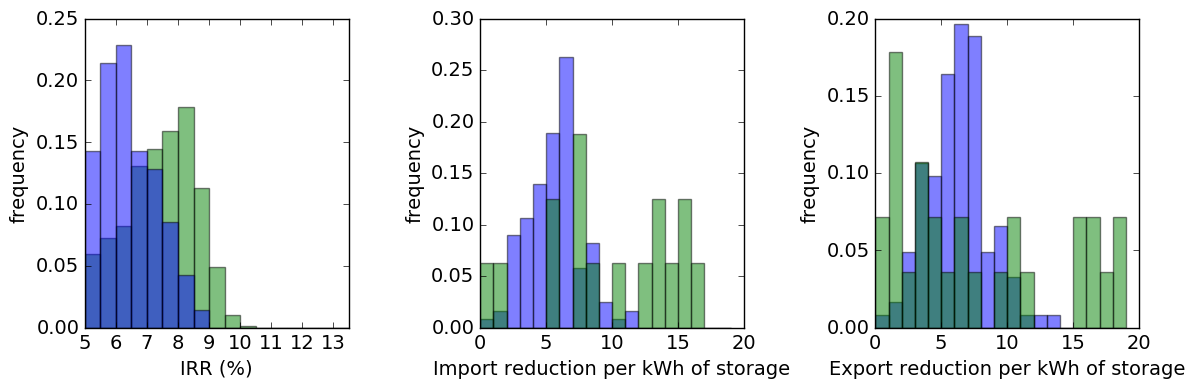

In [20]:
EAB = np.zeros((4574))
for i in range(4574):
    if Ind_stReq[i]>0:
        EAB[i] = 12*Ind_benefit[i]/Ind_stReq[i]
MEAB = np.zeros((kcluster))
for i in range(kcluster):
    if MG_stReq[i]>0:
        MEAB[i] = 12*MG_benefit[i]/MG_stReq[i]

# plot histogram of IRR's
IRR_Bins = np.arange(5,15,0.5)
IRR_Hist, IRR_edges = np.histogram(Ind_IRR[Ind_IRR>0]*100, IRR_Bins, density=False)
IRR_Widths = IRR_edges[1:]-IRR_edges[:-1]
fig = plt.figure()
fig.set_size_inches(12,4)
ax1 = fig.add_subplot(131)
ax1.bar(IRR_Bins[:-1], IRR_Hist/float(np.sum(IRR_Hist)), width=IRR_Widths, color='g', alpha=0.5)
ax1.set_xlabel('IRR (%)',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
MIRR_Hist, IRR_edges = np.histogram(MG_IRR[MG_IRR>0]*100, IRR_Bins, density=False)
ax1.bar(IRR_Bins[:-1], MIRR_Hist/float(np.sum(MIRR_Hist)), width=IRR_Widths, color='b', alpha=0.5)
ax1.set_xlim([5,13.5])

ImportRedMG = np.zeros(kcluster)
ImportRedInd = np.zeros(kcluster)
for i in range(kcluster):
    load1 = MG_dem_solar[i,:]
    load2 = MG_dem_storage[i,:]
    if MG_stReq[i]>0:
        ImportRedMG[i] = Delta_t*( np.sum(load1[load1>0]) - np.sum(load2[load2>0]) ) / MG_stReq[i]
    load3 = MG_dem_ind_storage[i,:]
    if Ind_stReq[i]>0:
        ImportRedInd[i] = Delta_t*( np.sum(load1[load1>0]) - np.sum(load3[load3>0]) ) / Ind_stReq[i]
    
Imp_Bins = np.arange(0.01,20,1)
Imp_Hist, Imp_edges = np.histogram(ImportRedMG, Imp_Bins, density=False)
Imp_Widths = Imp_edges[1:]-Imp_edges[:-1]
ax1 = fig.add_subplot(132)
ax1.bar(Imp_Bins[:-1], Imp_Hist/float(np.sum(Imp_Hist)), width=Imp_Widths, color='b', alpha=0.5)
Imp_Hist, Imp_edges = np.histogram(ImportRedInd, Imp_Bins, density=False)
ax1.bar(Imp_Bins[:-1], Imp_Hist/float(np.sum(Imp_Hist)), width=Imp_Widths, color='g', alpha=0.5)
ax1.set_xlabel('Import reduction per kWh of storage',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

ExportRedMG = np.zeros(kcluster)
ExportRedInd = np.zeros(kcluster)
for i in range(kcluster):
    load1 = MG_dem_solar[i,:]
    load2 = MG_dem_storage[i,:]
    if MG_stReq[i]>0:
        ExportRedMG[i] = -Delta_t*( np.sum(load1[load1<0]) - np.sum(load2[load2<0]) ) / MG_stReq[i]
    load3 = MG_dem_ind_storage[i,:]
    if Ind_stReq[i]>0:
        ExportRedInd[i] = -Delta_t*( np.sum(load1[load1<0]) - np.sum(load3[load3<0]) ) / Ind_stReq[i]
    
Exp_Hist, Imp_edges = np.histogram(ExportRedMG, Imp_Bins, density=False)
ax1 = fig.add_subplot(133)
ax1.bar(Imp_Bins[:-1], Exp_Hist/float(np.sum(Exp_Hist)), width=Imp_Widths, color='b', alpha=0.5)
Exp_Hist, Imp_edges = np.histogram(ExportRedInd, Imp_Bins, density=False)
ax1.bar(Imp_Bins[:-1], Exp_Hist/float(np.sum(Exp_Hist)), width=Imp_Widths, color='g', alpha=0.5)

ax1.set_xlabel('Export reduction per kWh of storage',fontsize=fs)
ax1.set_ylabel('frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater


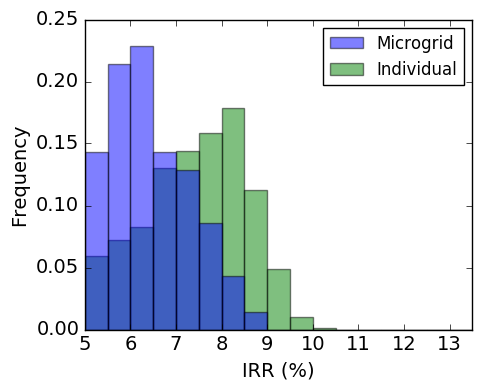

In [21]:
EAB = np.zeros((4574))
for i in range(4574):
    if Ind_stReq[i]>0:
        EAB[i] = 12*Ind_benefit[i]/Ind_stReq[i]
MEAB = np.zeros((kcluster))
for i in range(kcluster):
    if MG_stReq[i]>0:
        MEAB[i] = 12*MG_benefit[i]/MG_stReq[i]

# plot histogram of IRR's
IRR_Bins = np.arange(5,15,0.5)
IRR_Hist, IRR_edges = np.histogram(Ind_IRR[Ind_IRR>0]*100, IRR_Bins, density=False)
IRR_Widths = IRR_edges[1:]-IRR_edges[:-1]
fig = plt.figure()
fig.set_size_inches(5,4)
ax1 = fig.add_subplot(111)
ax1.bar(IRR_Bins[:-1], IRR_Hist/float(np.sum(IRR_Hist)), width=IRR_Widths, color='g', alpha=0.5)
ax1.set_xlabel('IRR (%)',fontsize=fs)
ax1.set_ylabel('Frequency',fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)
MIRR_Hist, IRR_edges = np.histogram(MG_IRR[MG_IRR>0]*100, IRR_Bins, density=False)
ax1.bar(IRR_Bins[:-1], MIRR_Hist/float(np.sum(MIRR_Hist)), width=IRR_Widths, color='b', alpha=0.5)
ax1.set_xlim([5,13.5])

r1 = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.5)
ax1.legend([r1,r2], ['Microgrid', 'Individual'], loc=1)
#fig.savefig('Images/IRRs.png', dpi=300, format='png',  bbox_inches='tight')